# Conv VAE Fmnist

In [1]:
import os 
import glob as glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Download Fmnist from: https://www.kaggle.com/zalando-research/fashionmnist

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values

X_train, X_valid = X_train/255, X_valid/255

In [4]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_valid = X_valid.reshape(X_valid.shape[0],28,28,1)

In [5]:
X_valid.shape

(10000, 28, 28, 1)

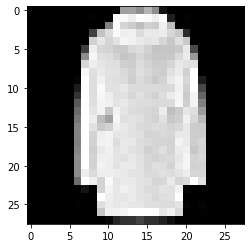

In [6]:
plt.imshow(X_train[6,:,:,0], cmap="gray")
plt.show()

## Model

$$
E_{z \sim Q}[\log P(X|z)]  - D[Q(z|X)||P(z)]
$$

* z is latent variable
* P(X|z) says given z what is the prob the reconstruction is like real data
* D[Q(z|X)||P(z)] measure similarity between generated latent and real latent

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
"""
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.SeparableConv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.SeparableConv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 14, 14, 32)   73          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 7, 7, 64)     2400        separable_conv2d[0][0]           
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           separable_conv2d_1[0][0]         
____________________________________________________________________________________________

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [10]:
# https://keras.io/guides/customizing_what_happens_in_fit/
# https://www.youtube.com/watch?v=h0UE8FzdE8U

class VAE(keras.Model):
    def __init__(self, encoder, decoder,n_pixels,Beta=1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.n_pixels = n_pixels
        self.Beta = Beta

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= self.n_pixels
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss*self.Beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= self.n_pixels
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss*self.Beta
        return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
        }    

In [11]:
n_pixels = 28*28*1

vae = VAE(encoder, decoder,n_pixels,Beta=1)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train,X_train,validation_data=(X_valid,X_valid), epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 47s 100ms/step - loss: 350.6945 - reconstruction_loss: 346.2111 - kl_loss: 4.4834 - val_loss: 352.2541 - val_reconstruction_loss: 347.8561 - val_kl_loss: 4.3979
Epoch 2/30
469/469 [==============================] - 48s 103ms/step - loss: 296.5676 - reconstruction_loss: 290.8024 - kl_loss: 5.7652 - val_loss: 311.2231 - val_reconstruction_loss: 305.9604 - val_kl_loss: 5.2628
Epoch 3/30
469/469 [==============================] - 47s 100ms/step - loss: 275.8469 - reconstruction_loss: 270.9225 - kl_loss: 4.9244 - val_loss: 305.7723 - val_reconstruction_loss: 301.0764 - val_kl_loss: 4.6959
Epoch 4/30
469/469 [==============================] - 47s 99ms/step - loss: 271.8163 - reconstruction_loss: 267.2224 - kl_loss: 4.5938 - val_loss: 304.0754 - val_reconstruction_loss: 299.5120 - val_kl_loss: 4.5634
Epoch 5/30
469/469 [==============================] - 51s 108ms/step - loss: 269.6684 - reconstruction_loss: 265.2128 - kl_loss: 4.4556 - val

## Generate Sample

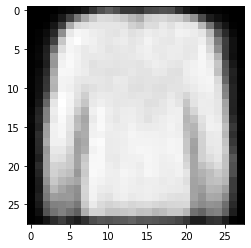

In [12]:
codings = tf.random.normal(shape=[1, latent_dim])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()

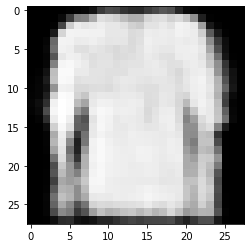

In [13]:
codings = tf.random.normal(shape=[1, latent_dim])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()

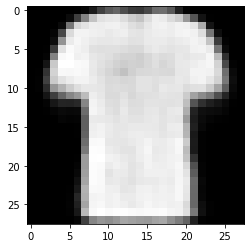

In [27]:
codings = tf.random.normal(shape=[1, latent_dim])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()

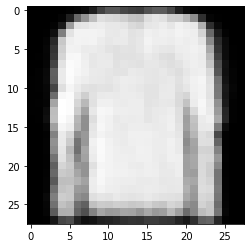

In [26]:
codings = tf.random.normal(shape=[1, latent_dim])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()

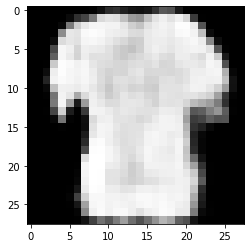

In [36]:
codings = tf.random.normal(shape=[1, latent_dim])
images = decoder(codings).numpy()
plt.imshow(images[0,:,:,0], cmap="gray")
plt.show()